General imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from plotstyle.export import save_timestamped_figure
from plotstyle.colors import cambridge_light, cambridge_core
from plotstyle.size import get_dim, WIDTH, GOLDEN_RATIO

SAVE = True
SAVE_DIR = "./figures/data_analysis"

Load data

In [2]:
# Load data
from lrdms.data.predictions import VariantPredictions
from lrdms.constants import DATA_PATH
from lrdms.data.srired import IRED

srired = IRED(DATA_PATH / "srired_active_data.csv")
srired.compute_mutation_coverage(orders=[1, 2, 3]);

2024-05-29 02:04:48.915 | INFO     | lrdms.data.srired:_process_raw_data:44 - Remove 0 NaN sequences
2024-05-29 02:04:48.916 | INFO     | lrdms.data.srired:_process_raw_data:48 - Remove 0 NaN fitness values
2024-05-29 02:04:48.919 | INFO     | lrdms.data.srired:_process_raw_data:53 - Remove 1320 sequences not ending in stop
2024-05-29 02:04:48.927 | INFO     | lrdms.data.srired:_process_raw_data:59 - Remove 981 sequences with intermediate stop
2024-05-29 02:04:48.946 | INFO     | lrdms.data.srired:_process_raw_data:70 - Remove 0 sequences with non-standard AAs
2024-05-29 02:04:48.950 | INFO     | lrdms.data.srired:_process_raw_data:75 - Remove 15 sequences with length != 290
2024-05-29 02:04:48.954 | INFO     | lrdms.data.srired:_process_raw_data:81 - Remove 3 sequences with >15 mutations
2024-05-29 02:04:48.956 | INFO     | lrdms.data.srired:_process_raw_data:93 - Parsing variants from sequences
2024-05-29 02:04:49.086 | INFO     | lrdms.data.srired:_process_raw_data:98 - Evaluating r

Plot fitness data distribution overall

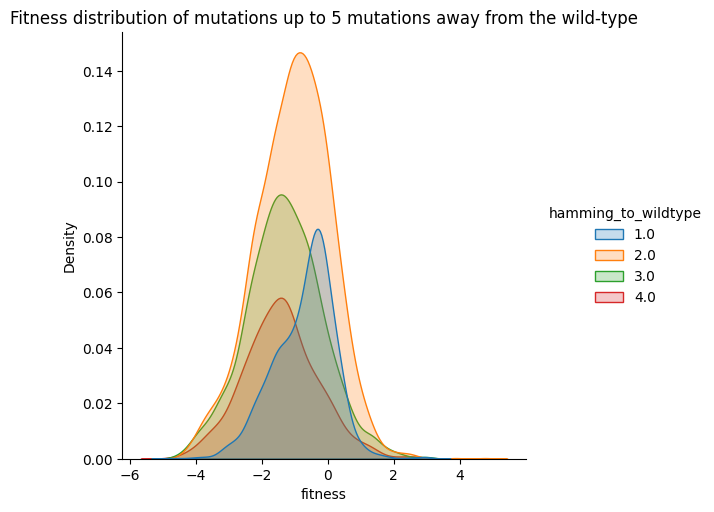

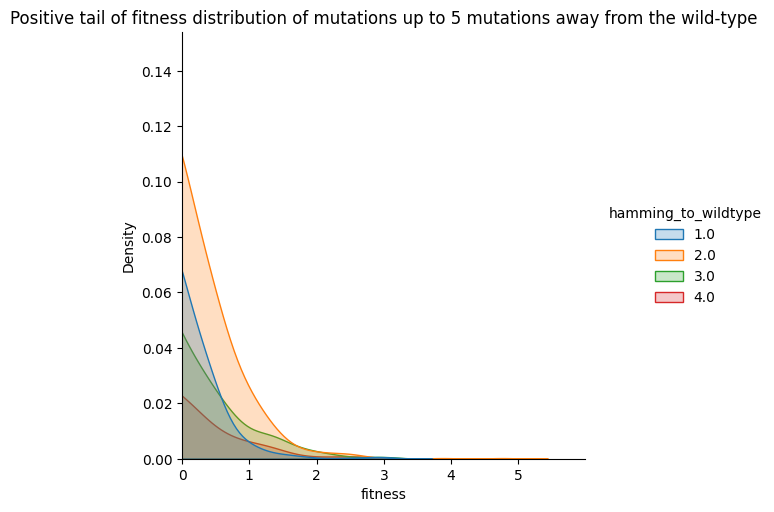

In [3]:
sns.displot(
    srired.data.query("0 < hamming_to_wildtype < 5"),
    x="fitness",
    hue="hamming_to_wildtype",
    kind="kde",
    fill=True,
    palette=sns.palettes.color_palette("tab10", n_colors=4),
)
plt.title("Fitness distribution of mutations up to 5 mutations away from the wild-type")
plt.show()

sns.displot(
    srired.data.query("0 < hamming_to_wildtype < 5"),
    x="fitness",
    hue="hamming_to_wildtype",
    kind="kde",
    fill=True,
    palette=sns.palettes.color_palette("tab10", n_colors=4),
)
plt.xlim(0, None)
plt.title("Positive tail of fitness distribution of mutations up to 5 mutations away from the wild-type")
plt.show()

Plot mutation coverage of higher order mutants by singles and doubles

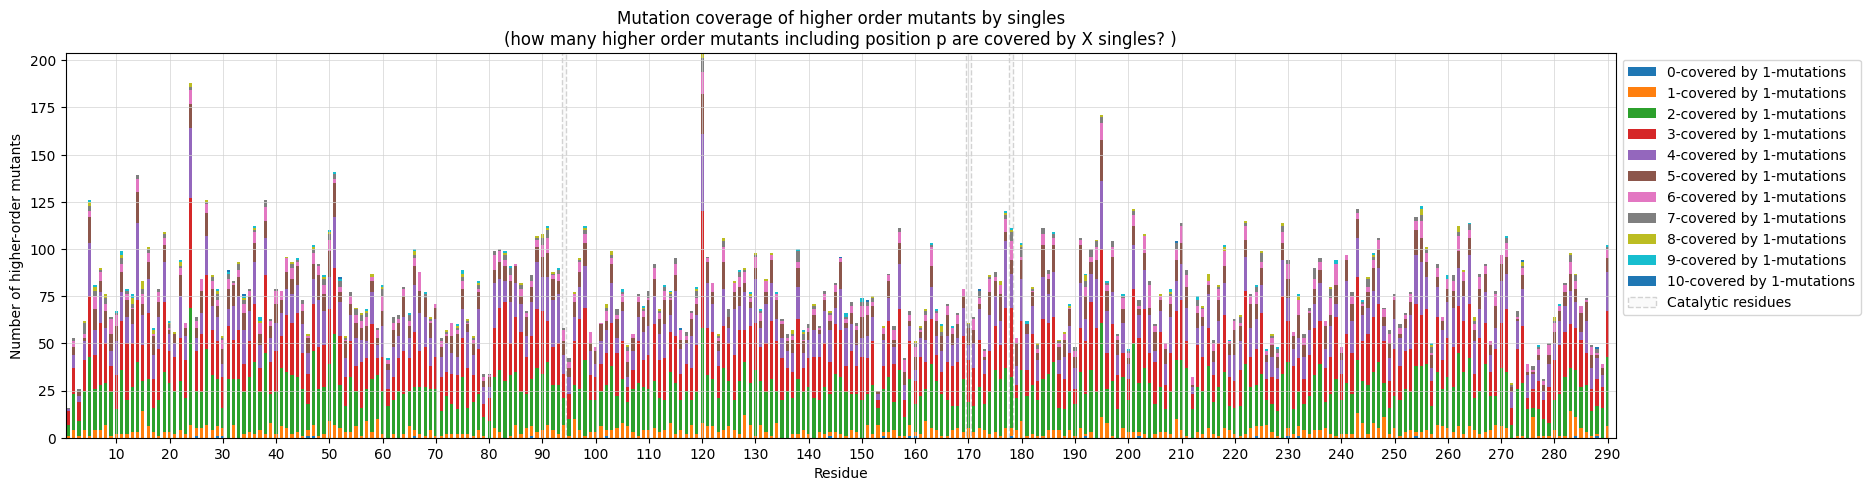

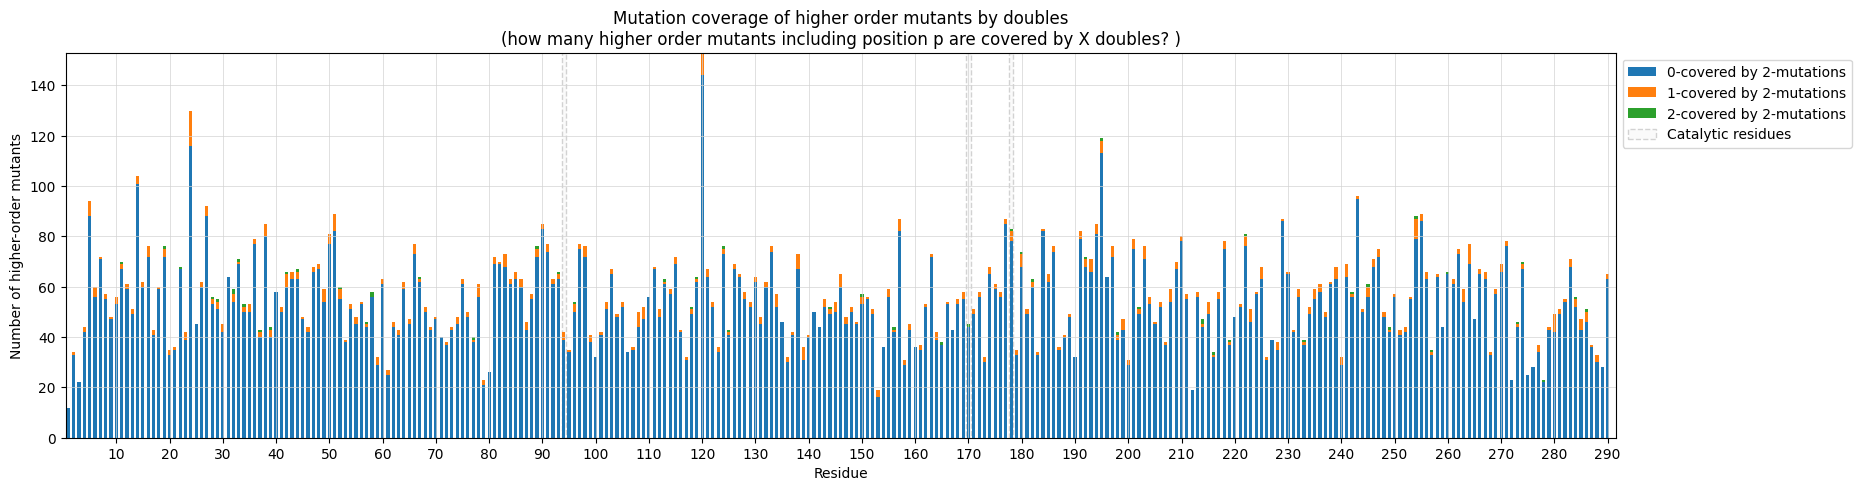

In [4]:
srired.plot_mutation_coverage(order=1)
plt.title(
    "Mutation coverage of higher order mutants by singles\n(how many higher order mutants including position p are covered by X singles? )"
)
plt.show()

srired.plot_mutation_coverage(order=2)
plt.title(
    "Mutation coverage of higher order mutants by doubles\n(how many higher order mutants including position p are covered by X doubles? )"
);

Plot min, median and max fitness of single mutants along the sequence

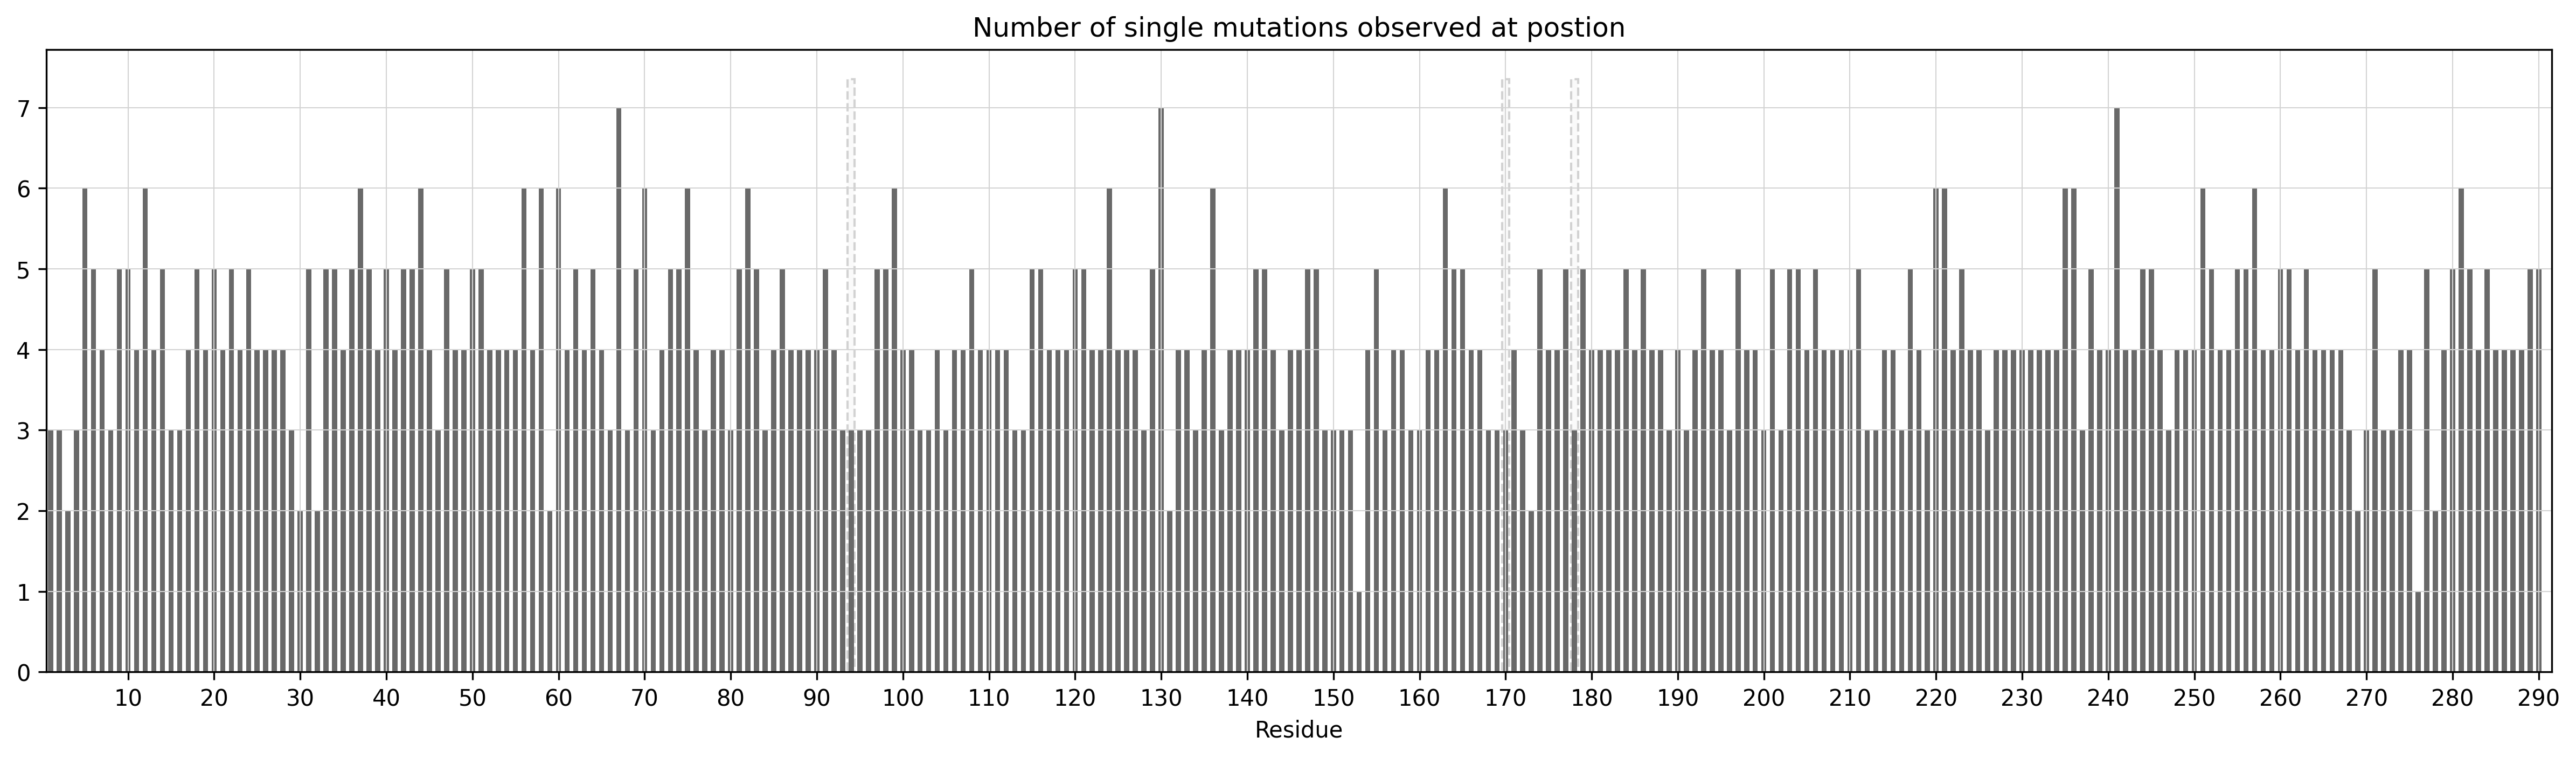

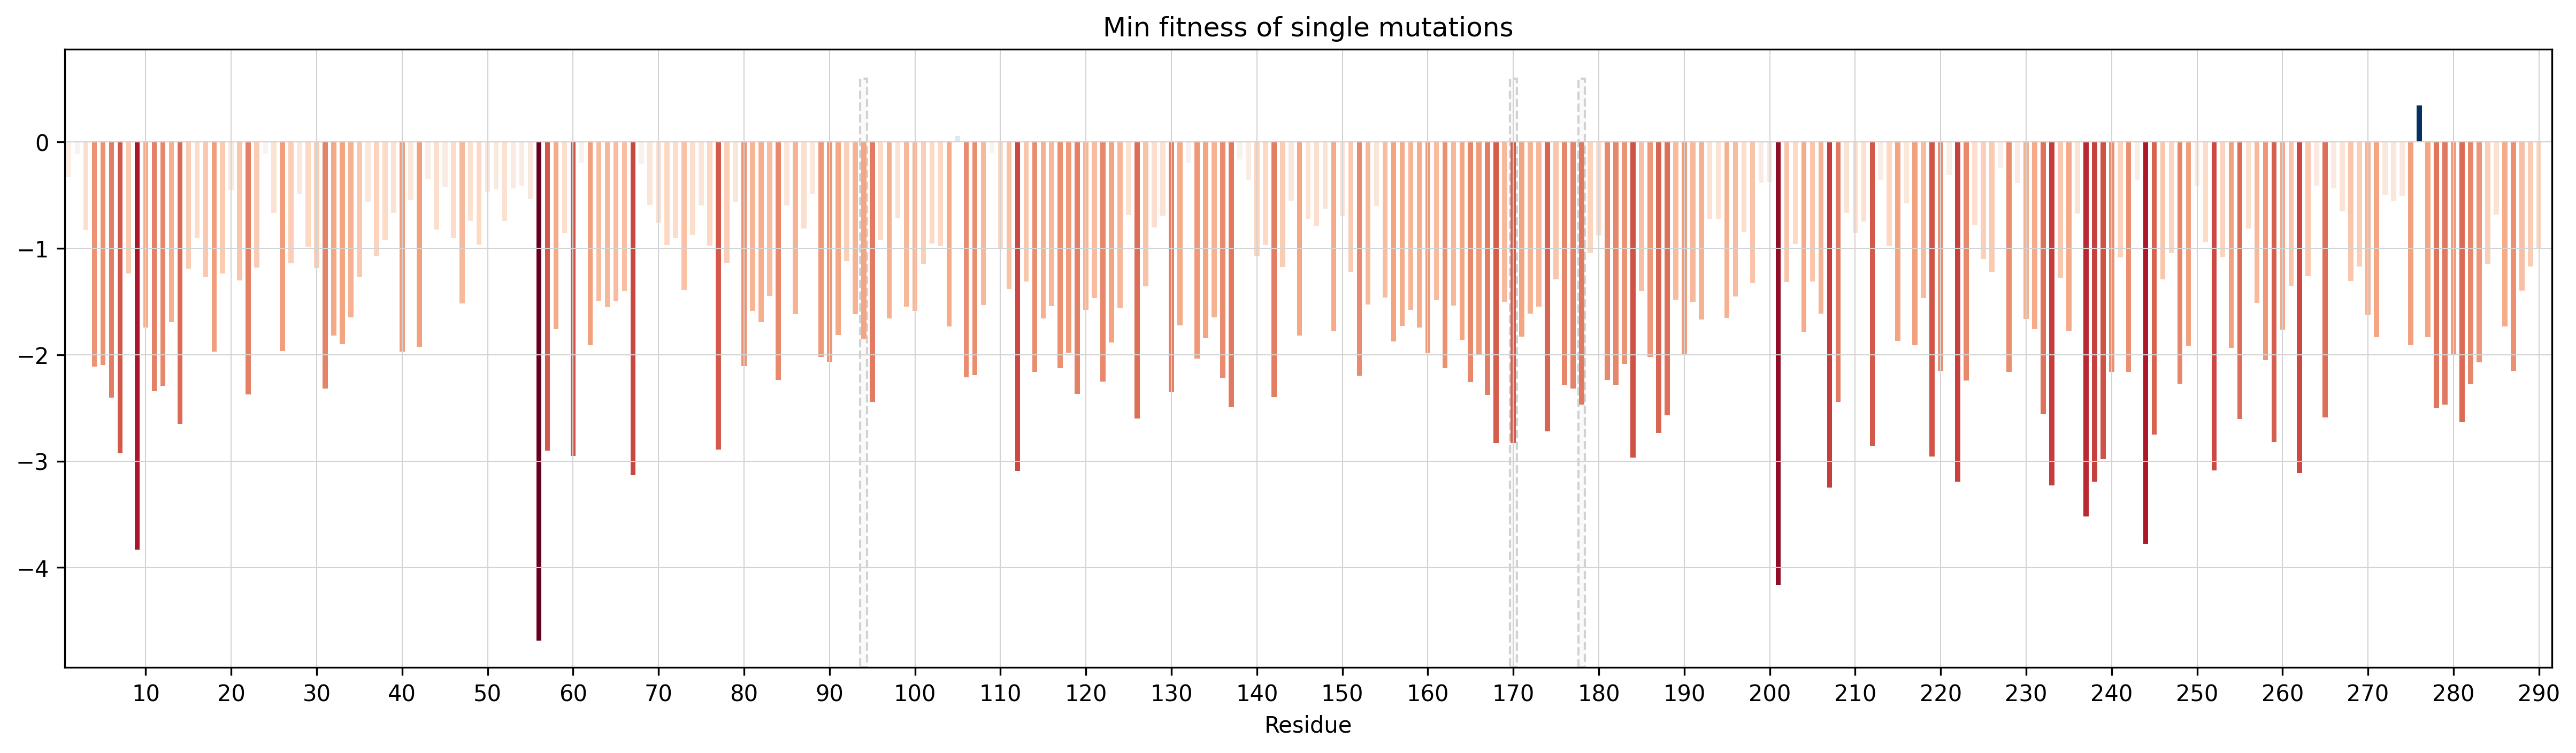

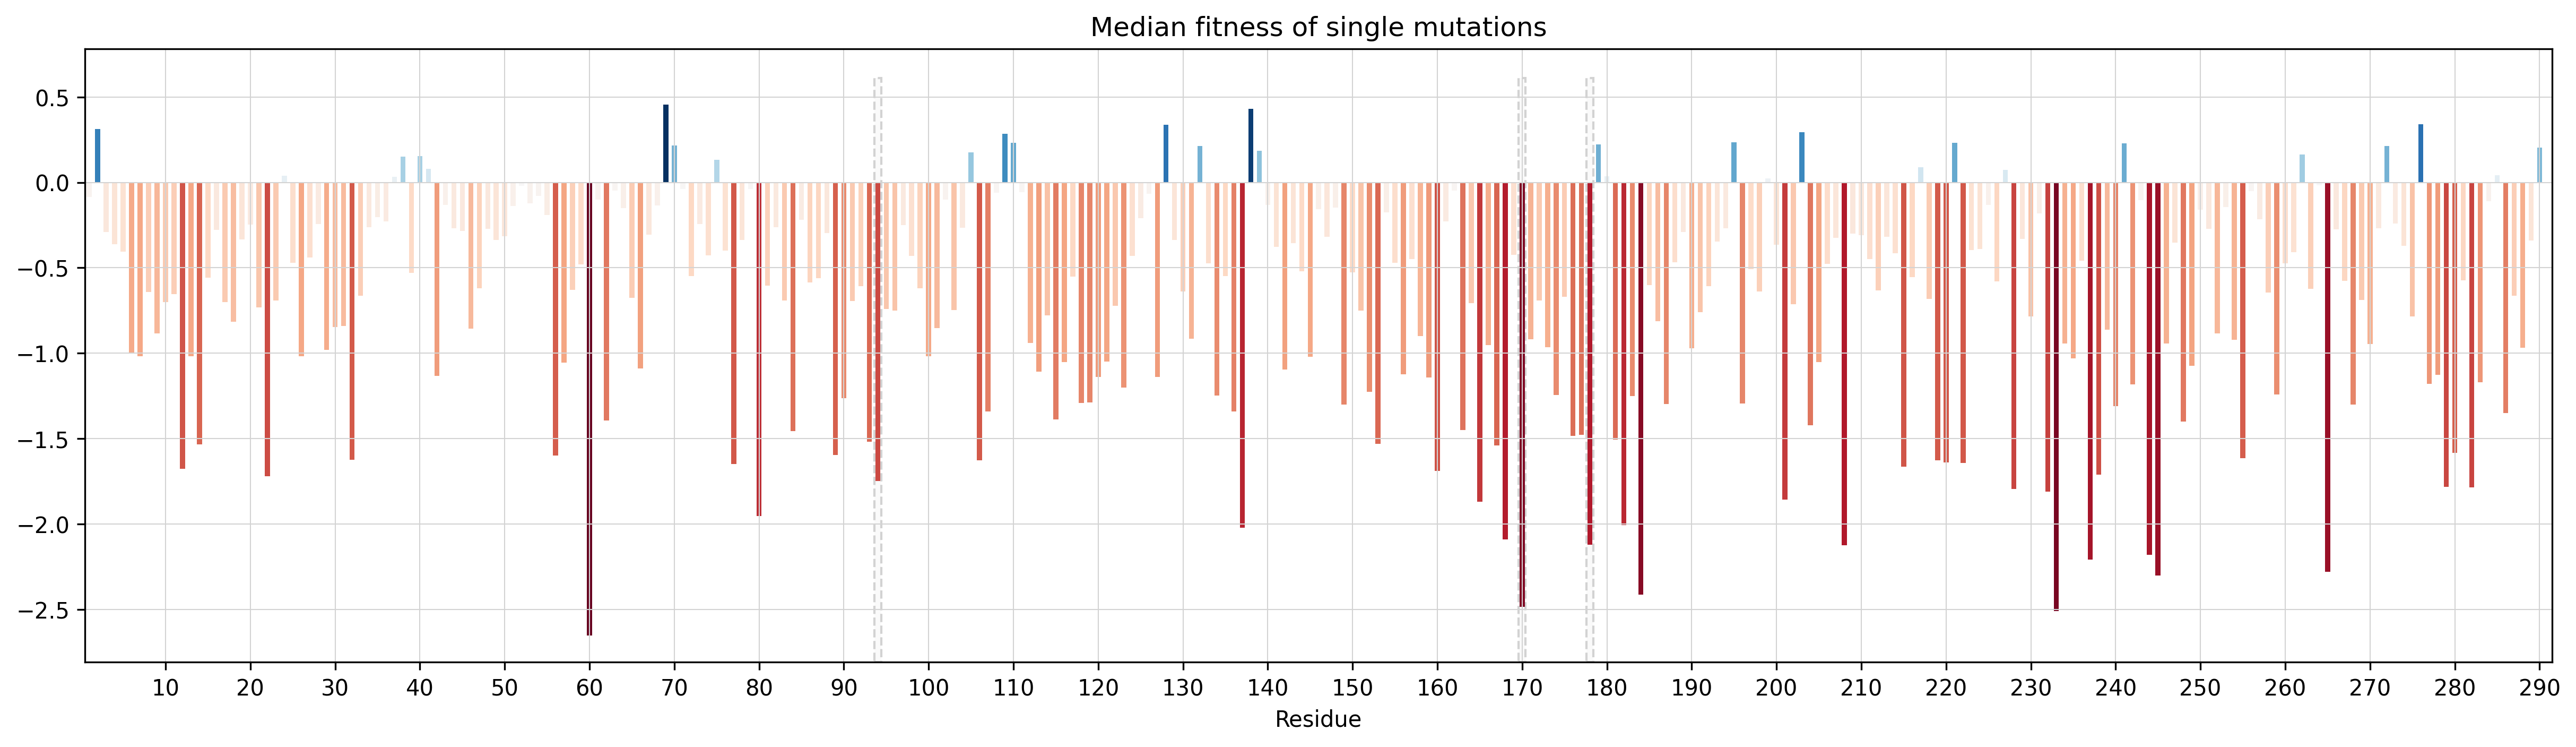

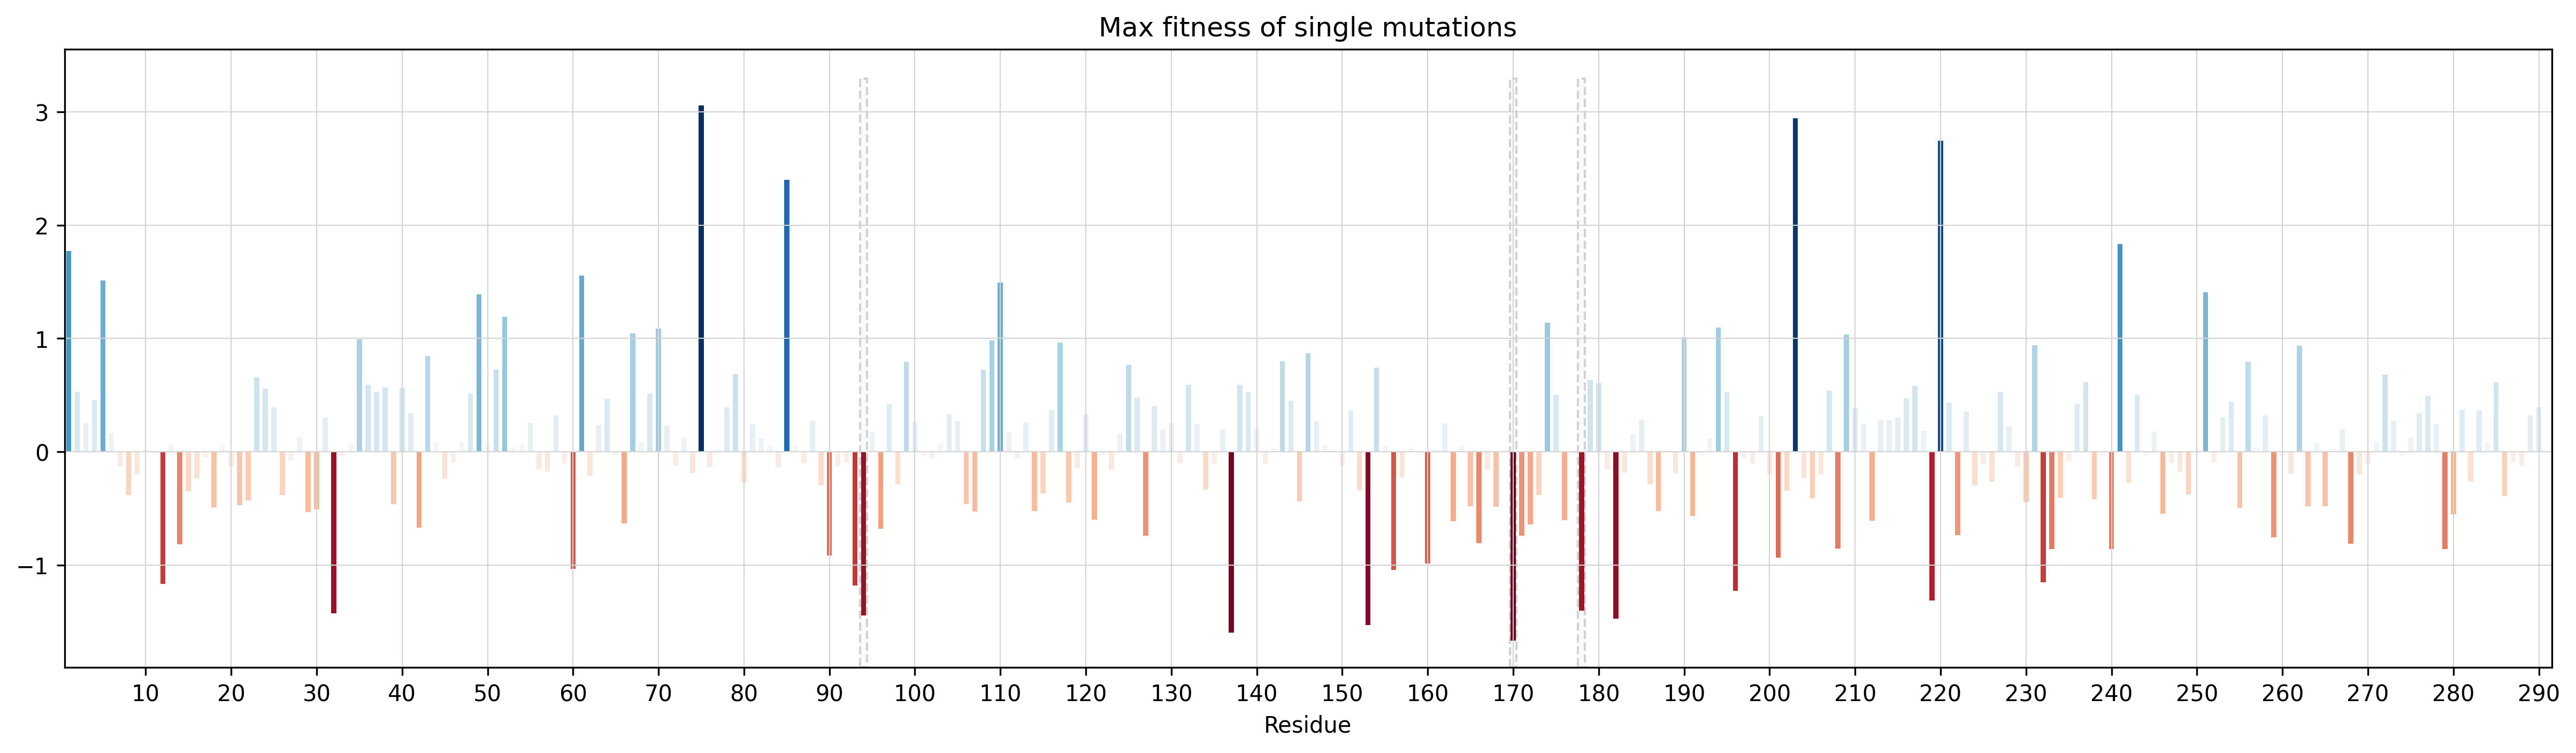

In [5]:
srired.data["single_pos"] = srired.data.query("hamming_to_wildtype == 1").variant.apply(lambda x: int(x[1:-1]))

srired.plot_along_sequence(
    srired.data.query("hamming_to_wildtype == 1").groupby("single_pos").fitness.count(),
    title="Number of single mutations observed at postion",
)

srired.plot_along_sequence(
    srired.data.query("hamming_to_wildtype == 1").groupby("single_pos").fitness.min(),
    title="Min fitness of single mutations",
    hue=srired.data.query("hamming_to_wildtype == 1").groupby("single_pos").fitness.min(),
)

srired.plot_along_sequence(
    srired.data.query("hamming_to_wildtype == 1").groupby("single_pos").fitness.median(),
    title="Median fitness of single mutations",
    hue=srired.data.query("hamming_to_wildtype == 1").groupby("single_pos").fitness.median(),
)

srired.plot_along_sequence(
    srired.data.query("hamming_to_wildtype == 1").groupby("single_pos").fitness.max(),
    title="Max fitness of single mutations",
    hue=srired.data.query("hamming_to_wildtype == 1").groupby("single_pos").fitness.max(),
);

## Mutability and Combinability analysis along the sequence

Compute structure derived features for annotation

In [6]:
from biotite.database import rcsb
from lrdms.features.structure import (
    load_protein_and_ligands,
    calc_residue_rsasa,
    get_min_distance_to_reference_points,
    get_interface_distances,
)
import biotite.structure as bs

protein, ligands = load_protein_and_ligands(DATA_PATH / "5ocm.cif")

# Calculate structural features
# ... rsasa
rasas = calc_residue_rsasa(protein)
protein.set_annotation("rsasa", bs.spread_residue_wise(protein, rasas))

# ... distance to dimer interface
distance_to_interface = get_interface_distances(protein)
protein.set_annotation("atom_dimer_dist", np.concatenate([distance_to_interface["A>F"], distance_to_interface["F>A"]]))
protein.set_annotation(
    "res_dimer_dist", bs.spread_residue_wise(protein, bs.apply_residue_wise(protein, protein.atom_dimer_dist, np.min))
)

# ... distance to catalytic residues
catalytic_res = protein[
    np.isin(protein.res_id, np.array(srired.catalytic_residues) + 1)
]  # NOTE: CIF files use 1-indexing
catalytic_dist = get_min_distance_to_reference_points(protein, catalytic_res.coord)
protein.set_annotation("atom_catalytic_dist", catalytic_dist)
protein.set_annotation(
    "res_catalytic_dist", bs.spread_residue_wise(protein, bs.apply_residue_wise(protein, catalytic_dist, np.min))
)

# ... secondary structure
sse = bs.annotate_sse(protein)
protein.set_annotation("secondary_structure", bs.spread_residue_wise(protein, sse))

# ... NMA MSQF
from lrdms.features.dynamics import calculate_nma_msqf

res_msqf = calculate_nma_msqf(protein)
protein.set_annotation("res_msqf", bs.spread_residue_wise(protein, res_msqf))

# ... collect data in df
# Turn into dataframe:
structure_feat_df = pd.DataFrame(
    {
        "chain_id": protein.chain_id,
        "res_id": protein.res_id,
        "res_name": protein.res_name,
        "atom_name": protein.atom_name,
        "rsasa": protein.rsasa,
        "res_dimer_dist": protein.res_dimer_dist,
        "atom_dimer_dist": protein.atom_dimer_dist,
        "atom_catalytic_dist": protein.atom_catalytic_dist,
        "res_catalytic_dist": protein.res_catalytic_dist,
        "secondary_structure": protein.secondary_structure,
        "res_msqf": protein.res_msqf,
    }
)

# Pool structural features across the two chains & across the atoms for each residue to get
# sequence-level features
structural_data = structure_feat_df.groupby(["res_id"]).agg(
    {
        "rsasa": "mean",
        "res_dimer_dist": "min",
        "atom_dimer_dist": "min",
        "atom_dimer_dist": "min",
        "secondary_structure": "min",
        "atom_catalytic_dist": "min",
        "res_catalytic_dist": "min",
        "res_msqf": "mean",
    }
)

Compute assay derived features (mutability & combinability).

NOTE: This definition of combinability follows the formula in the paper and is more robust than
    combinability v1 by considering uncertainties and comparing to the additive fitness of the
    singles mutations. It is this definition that was used  rational designs and is recommended for general use,
    in the future due to it's increased robustness vs (v1), but it was not used in the version of the double-mutant 
    model that we took to the lab. That version used combinability_v1

In [7]:
from lrdms.features.dms import compute_combinability_v2

# Compute data derived features
# ... median fitness (from singles)
singles = srired.data.query("hamming_to_wildtype == 1").copy()
singles["pos"] = singles.variant.str.findall("\d+").apply(lambda x: int(x[0]))
median_fitness = singles.groupby("pos")["fitness"].median()
median_fitness = median_fitness.reindex(range(1, srired.sequence_length + 1), fill_value=np.nan)

# ... combinability
combinability = compute_combinability_v2(
    srired.data,
    srired.sequence_length,
    mutorder_col="hamming_to_wildtype",
    variant_col="variant",
    fitness_thres=srired.wildtype_fitness,
)

/Users/simon/code/lrDMS-IRED/src/lrdms/features/dms.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Add manual annotation data about substrate which is not modelled in the structure

In [8]:
# 1-indexed
catalytic_res = np.array(srired.catalytic_residues) + 1
first_shell_res_ketone_amine = [
    92,
    93,
    117,
    118,
    119,
    120,
    121,
    122,
    174,
    177,
    208,
    215,
    232,
    233,
    234,
    237,
    238,
    241,
] + catalytic_res.tolist()
first_shell_res_nadph = structural_data.query("res_catalytic_dist < 6.0").index.values
dimer_interface = structural_data.query("res_dimer_dist < 6.0").index.values
surface_res = structural_data.query("rsasa > 0.25").index.values

Plot trace along sequence

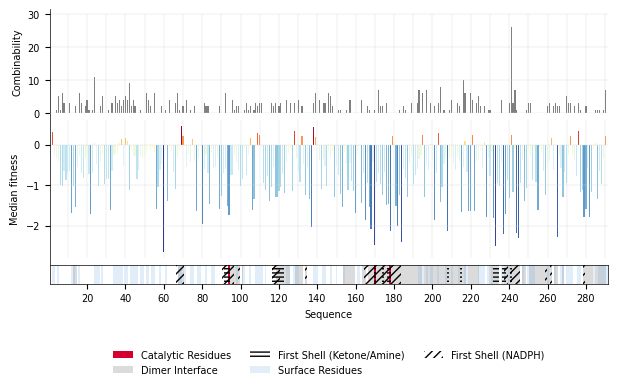

In [9]:
import matplotlib.patches as patches
import matplotlib

sequence_length = srired.sequence_length
cnorm = None
cmap = "RdYlBu_r"

with plt.style.context(["nature"]):
    mpl.rcParams["hatch.linewidth"] = 1  # or any other float value for thickness

    # Create a figure and axis
    fig, axes = plt.subplots(
        figsize=get_dim(WIDTH.nature_2column, ratio=GOLDEN_RATIO * 0.8),
        nrows=3,
        height_ratios=[0.34, 0.5, 0.06],
        sharex=False,
    )

    # Round the xticks to the nearest 10 and fit `_n_ticks` ticks
    _n_ticks = 20
    _step_size = round(int(np.ceil(sequence_length / _n_ticks)) / 10) * 10
    xticks = np.arange(0, sequence_length + 1, _step_size)  # +1 because mutation notation is 1 indexed

    values = combinability
    mark_catalytic_sites = True
    hue = None
    use_one_indexing = True
    color = "gray"
    cmap = "RdYlBu_r"

    ax = axes[0]

    # Bar plot along the sequence values
    offset = 1 if use_one_indexing else 0
    pos = np.arange(offset, sequence_length + offset)
    ax.bar(pos, values, align="center", width=0.6, color=color)

    ax.set_ylabel("Combinability")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    # Set yticks
    ax.set_yticks([0, 10, 20, 30])
    ax.set_xlim(offset - 0.5, sequence_length + offset + 0.5)

    # PLOT 2 -- Median fitness
    ax = axes[1]
    values = median_fitness
    hue = median_fitness

    # Set color map
    if hue is not None:
        assert len(hue) == sequence_length, "Hue must be the same length as the sequence"
        if cnorm is not None:
            pass
        elif hue.min() < 0 and hue.max() > 0:
            # set the color map to be diverging
            cnorm = mpl.colors.TwoSlopeNorm(vmin=hue.min(), vcenter=0.0, vmax=hue.max())
        else:
            # set the color map to be sequential
            cnorm = mpl.colors.Normalize(vmin=hue.min(), vmax=hue.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)
        sm.set_array([])
        cmap = plt.get_cmap(cmap)
        color = cmap(cnorm(hue))

    # Bar plot along the sequence values
    offset = 1 if use_one_indexing else 0
    pos = np.arange(offset, sequence_length + offset)
    ax.bar(pos, values, align="center", width=0.6, color=color)

    ax.set_ylabel("Median fitness")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(offset - 0.5, sequence_length + offset + 0.5)
    # Set xticks and use for grid but hide labels and tick marks

    # PLOT 3 -- Orientation bar
    ax = axes[2]

    # Function to add shaded or hatched areas
    def add_annotation(indices, color=None, hatch=None, alpha=0.99, width=1, height=1):
        for index in indices:
            if color is None:
                # Set transparent facecolor
                facecolor = (1, 1, 1, 0)  # Fully transparent white
            else:
                # Apply alpha only to facecolor, not to the hatch
                facecolor = (*matplotlib.colors.to_rgb(color), alpha)

            ax.add_patch(
                patches.Rectangle((index - 0.5, 0), width, height, facecolor=facecolor, hatch=hatch, edgecolor=None)
            )

    # Add your annotations
    add_annotation(dimer_interface, color="lightgray", alpha=0.8)
    add_annotation(surface_res, color=cambridge_light[1], alpha=0.2)
    add_annotation(catalytic_res, color=cambridge_core[0])
    add_annotation(first_shell_res_ketone_amine, hatch=r"-" * 4, alpha=0.99)
    add_annotation(first_shell_res_nadph, hatch="/" * 4, alpha=0.99)

    # Where there is overlap between first_shell_res_ketone_amine and first_shell_res_nadph, the hatch pattern should be "x"
    overlap = np.intersect1d(first_shell_res_ketone_amine, first_shell_res_nadph)
    # add_annotation(overlap, hatch='x'*4, alpha=0)

    # Set limits and labels
    ax.set_xlim(0, 289)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Sequence")
    ax.set_yticks([])  # Hide y-axis ticks
    ax.set_xticks(xticks)
    ax.set_xlim(offset - 0.5, sequence_length + offset + 0.5)

    # Make grid lines thinner and in the background
    for ax in axes[:-1]:
        ax.set_xticks([])
        ymin, ymax = ax.get_ylim()
        for x in range(0, sequence_length + 1, 10):
            ax.vlines(x, ymin=ymin, ymax=ymax, colors="lightgray", linestyles="-", lw=0.25, zorder=-1)
        # Set y-grid at minor ticks with same linewidth and zorder as the bars
        ax.grid(axis="y", which="major", color="lightgray", linestyle="-", lw=0.25, zorder=-1)

    # Add legend
    legend_elements = [
        patches.Patch(facecolor=cambridge_core[0], edgecolor=None, label="Catalytic Residues"),
        patches.Patch(facecolor="lightgray", edgecolor=None, label="Dimer Interface", alpha=0.8),
        patches.Patch(facecolor="white", hatch=r"-" * 4, edgecolor=None, label="First Shell (Ketone/Amine)"),
        patches.Patch(facecolor=cambridge_light[1], edgecolor=None, label="Surface Residues", alpha=0.2),
        patches.Patch(facecolor="white", hatch="/" * 4, edgecolor=None, label="First Shell (NADPH)"),
    ]

    ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.5), ncol=3, frameon=False)

    # Remove vertical padding between subplots
    fig.subplots_adjust(hspace=0.0)


# Save figure
if SAVE:
    save_timestamped_figure("combinability_median_fitness", SAVE_DIR, file_types=["pdf"], date_format="")
plt.show()